## I. Các thư viện cần thiết

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
!pip install tensorflow_addons

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import tensorflow as tf
import tensorflow_addons as tfa

# II. Dữ liệu


## 1. Tổng quan

In [10]:
base_dir = '/content/drive/MyDrive/Colab Notebooks/UDDLL/Data/Youtube Crawl/Preprocess/'

In [11]:
df_train = pd.read_csv(base_dir+'Crawl_youtube_train.csv', usecols=['sentence', 'sentiment'])

df_train

,sentence,sentiment
0,Hay,positive
1,Bài này không thấy trên zing_nhỉ mọi người,neutral
2,2000000000000000000000000000000000000000000000...,positive
3,xem chan_co gi buon cuoi het,negative
4,2023 CÒN AI KO,neutral
...,...,...
9555,"Bài của Đen rất ý_nghĩa , .. Tuy_rằng cùng tra...",positive
9556,"YÊU cách rap của chú Đen_Vâu , THÍCH giọng ấm_...",positive
9557,"NE là cô gái thật_thà , xinh_đẹp , ngây_thơ rấ...",positive
9558,"Trường_Giang là dân_quãng , mà dân_quãng ngươ ...",neutral


In [12]:
df_test = pd.read_csv(base_dir+'Crawl_youtube_test.csv', usecols=['sentence', 'sentiment'])
df_test

,sentence,sentiment
0,Nhiều view vãi,positive
1,.,neutral
2,Cảm_ơn Đen_Vâu vì tuyệt_tác này .,positive
3,Cười ỉa ngay đoạn 16 p32,positive
4,Đây dòi ......_From Cris with love,positive
...,...,...
2386,Toàn hot girl ngồi dưới xem Thấy 1 cô gái xinh...,neutral
2387,Anh hat hay lam_hang tu,positive
2388,Áo của heo rừng đẹp ghê,positive
2389,988N like rồi cố 1 m like nào,positive


## 2. Trực quan

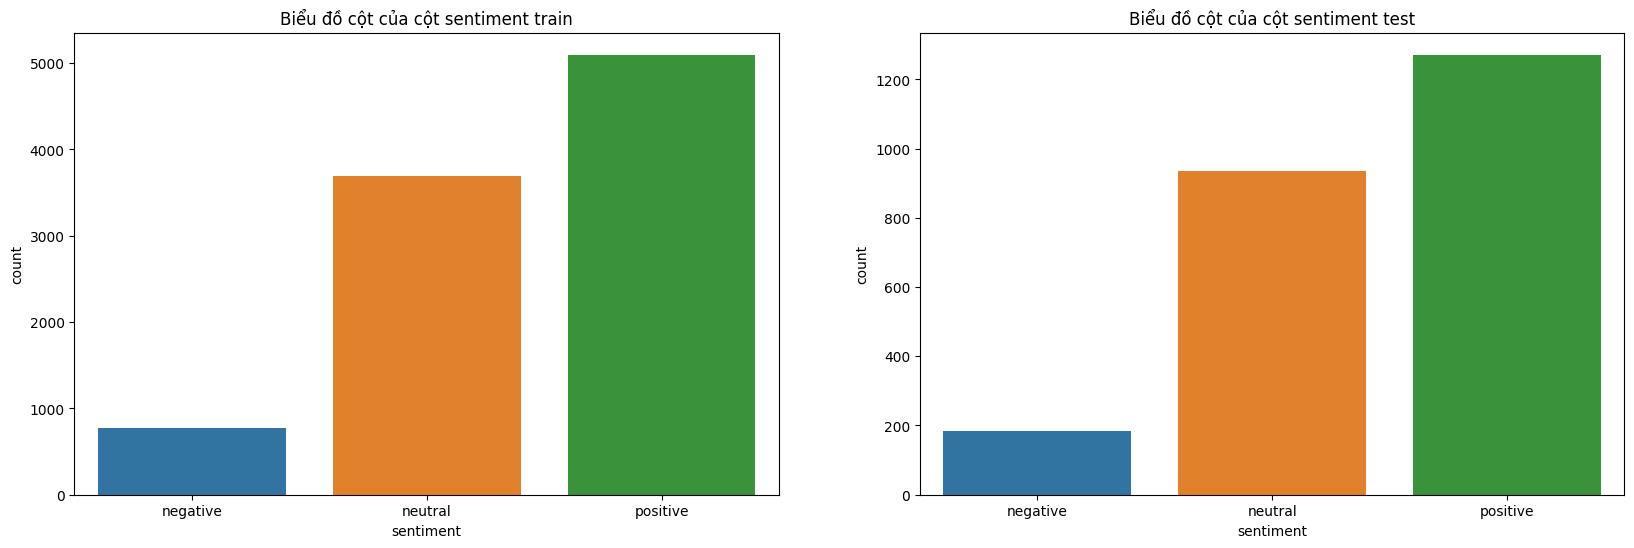

In [13]:
sentiment_train = df_train['sentiment']
sentiment_test = df_test['sentiment']

# Lấy danh sách các giá trị duy nhất từ cả hai tập dữ liệu, sắp xếp chúng
unique_values = sorted(list(set(sentiment_train.unique()).union(set(sentiment_test.unique()))))

# Tạo figure và axes
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

# Vẽ biểu đồ cho tập train
sns.countplot(x=sentiment_train, ax=ax[0], order=unique_values)
ax[0].set_title('Biểu đồ cột của cột sentiment train')

# Vẽ biểu đồ cho tập test
sns.countplot(x=sentiment_test, ax=ax[1], order=unique_values)
ax[1].set_title('Biểu đồ cột của cột sentiment test')

# Hiển thị biểu đồ
plt.show()


- Dữ liệu được phân chia thành 3 nhãn.
- Số lượng mẫu trong mỗi nhãn khá đồng đều với nhau


## 3. Chia tập dữ liệu

In [14]:
X_train = df_train.sentence.copy()
X_test = df_test.sentence.copy()

sentiment_train = df_train.sentiment.copy()
sentiment_test = df_test.sentiment.copy()

## 4. Chuyển về one-hot

In [15]:
# Khởi tạo LabelEncoder
encoder = LabelEncoder()

# Chuyển đổi nhãn dạng chuỗi thành nhãn dạng số
y_train_encoded = encoder.fit_transform(sentiment_train)
y_test_encoded = encoder.transform(sentiment_test)

# Chuyển đổi nhãn dạng số thành dạng one-hot
y_train = to_categorical(y_train_encoded)
y_test = to_categorical(y_test_encoded)

print(y_train)
print(encoder.classes_)

[[0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 ...
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]]
['negative' 'neutral' 'positive']


In [16]:
y_train.shape

(9560, 3)

# III. Cấu Hình môi trường (chiến lược):

Cấu hình để tận dụng tích hợp TPU (Tensor Processing Unit) hoặc
nhiều GPU (Graphics Processing Unit) trong TensorFlow, nhằm tăng tốc độ huấn luyện mô hình trên
nhiều thiết bị xử lý song song

In [17]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)

    strategy = tf.distribute.experimental.TPUStrategy
except ValueError:
    strategy = tf.distribute.get_strategy()
    print('Number of replicas:', strategy.num_replicas_in_sync)

Đoạn mã in ra thông tin về chiến lược phân phối đã
được chọn và số lượng accelerator (đơn vị xử lý, bao gồm cả TPU và GPU) sẽ được sử dụng trong quá
trình huấn luyện.

In [18]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
    tpu = None
    gpus = tf.config.experimental.list_logical_devices("GPU")

if tpu:
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu,)
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
    strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
    print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
    strategy = tf.distribute.get_strategy()
    print('Running on single GPU ', gpus[0].name)
else:
    strategy = tf.distribute.get_strategy()
    print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on TPU  ['10.13.111.218:8470']
Number of accelerators:  8


# IV. Xây dựng mô hình

In [19]:
from transformers import TFAutoModel, AutoTokenizer

## 1. Tạo Tokennizer

In [20]:
model_name = 'vinai/phobert-base'

# Tokenizing
tokenizer = AutoTokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

In [21]:
text = 'Đội ngũ bảo trì quá thưa thớt dẫn đến không đảm bảo được chất lượng sửa chữa thiết bị.'
print(tokenizer(text))
print(tokenizer(text,
                    max_length = 200,
                    padding = 'max_length',
                    truncation = True,
                    return_tensors = 'np')['input_ids'].reshape(200))

{'input_ids': [0, 1650, 15679, 1218, 23651, 204, 4532, 17908, 376, 30, 17, 15758, 1218, 11, 567, 525, 2833, 1661, 14945, 22842, 5, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
[    0  1650 15679  1218 23651   204  4532 17908   376    30    17 15758
  1218    11   567   525  2833  1661 14945 22842     5     2     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1

- input_ids: Đây là danh sách các ID đại diện cho từng token trong câu đầu vào. Mỗi số trong danh sách tương ứng với một token cụ thể trong từ điển của mô hình.
- token_type_ids: Đây là danh sách dùng để phân biệt các phần khác nhau của đầu vào, thường được sử dụng khi cần xử lý hai câu cùng một lúc (ví dụ: trong tác vụ phân loại câu đôi). Trong trường hợp này, tất cả các giá trị đều là 0, có nghĩa là chỉ có một phần đầu vào (1 câu).
- attention_mask: Đây là danh sách dùng để chỉ ra những token nào là thực sự có ý nghĩa trong câu, và những token nào chỉ là token đệm (padding). Giá trị 1 có nghĩa là token tương ứng cần được mô hình chú ý đến, và giá trị 0 có nghĩa là token đó là token đệm.
-> **Thao này giúp chuẩn hóa và biểu diễn các văn bản dưới dạng số để có thể đưa vào mô hình NLP**

In [22]:
MAX_LEN = 200
inputs_train = [tokenizer(item,
                    max_length = MAX_LEN,
                    padding = 'max_length',
                    truncation = True,
                    return_tensors = 'np')['input_ids'].reshape(MAX_LEN)
          for _, item in X_train.items()]

inputs_test = [tokenizer(item,
                    max_length = MAX_LEN,
                    padding = 'max_length',
                    truncation = True,
                    return_tensors = 'np')['input_ids'].reshape(MAX_LEN)
          for _, item in X_test.items()]

In [23]:
X_train = np.asarray(inputs_train)
X_test = np.asarray(inputs_test)

In [24]:
print(X_train)

[[    0  3896     2 ...     1     1     1]
 [    0  2215    23 ...     1     1     1]
 [    0  6744  5557 ...     1     1     1]
 ...
 [    0 27153     8 ...     1     1     1]
 [    0  4383     8 ...     1     1     1]
 [    0  6761   113 ...     1     1     1]]


In [25]:
from tensorflow.keras import Input, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Bidirectional, LSTM, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

- Mô hình PhoBert có 2 đầu ra:
  - Thể hiện ở dòng `PhoBert(input_ids)[1]`
  - Output thứ nhất: Đây là ma trận biểu diễn (embedding) cho mỗi token trong câu đầu vào
  - Output thứ hai: Đây là vector biểu diễn cho token `[CLS]` trong câu đầu vào. Token `[CLS]` thường được thêm vào đầu câu đầu vào và được sử dụng như một dạng biểu diễn toàn cục (global representation) của cả câu.
-> Cả hai output này đều chứa thông tin quan trọng và được sử dụng trong các tác vụ khác nhau. **Ví dụ, output thứ nhất** thường được sử dụng trong các tác vụ gán nhãn cho từng token (như gán nhãn từ loại, nhận dạng thực thể có tên,…), **trong khi output thứ hai** thường được sử dụng trong các tác vụ phân loại câu hoặc câu đôi (như phân loại cảm xúc, hiểu ngữ cảnh,…).

## 2. Khởi tạo mô hình

In [26]:
# Build model
with strategy.scope():
    PhoBert = TFAutoModel.from_pretrained(model_name) # Tải lên mô hình PhoBert

    input_ids = Input(shape=(MAX_LEN,), dtype=tf.int32) # Tạo một đối tượng Input trong TensorFlow

    embedding = PhoBert(input_ids)[1] # Truyền đầu vào input_ids vào mô hình PhoBert và lấy ra embedding tương ứng

    #  Tạo một lớp Dense với 128 nút, hàm kích hoạt ReLU, và sử dụng điều chuẩn L2 với hệ số 0.1. Lớp này nhận đầu vào là embedding
    x = Dense(128, activation = 'relu', kernel_regularizer = regularizers.L2(0.1))(embedding)
    # Tạo một lớp Dropout với tỷ lệ dropout là 0.2. Lớp này nhận đầu vào là output của lớp Dense trước đó.
    x = Dropout(0.2)(x)
    # Dòng này tạo một lớp Dense khác, với số lượng nút bằng với số lượng lớp trong encoder.classes_ (trong trường hợp này là 3)
    x = Dense(len(encoder.classes_),
              activation = 'softmax',
              kernel_initializer=tf.initializers.GlorotUniform(seed=1905),
              name='output_layer')(x)

    # Tạo một đối tượng Model trong TensorFlow, với đầu vào là input_ids và đầu ra là x.
    model = Model(inputs=[input_ids], outputs = x)

tf_model.h5:   0%|          | 0.00/740M [00:00<?, ?B/s]

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Hàm sofmax sẽ cho ra kết quả từ 0-1

Nguyên lý đằng sau hàm Softmax khá đơn giản. Với một vài số cho trước

- Tính hàm lũy thừa số e, với số mũ là những số đã cho
- Tính tổng các lũy thừa đó. Đó sẽ là mẫu số.
- Sử dụng lũy thừa của mỗi số là tử số
- Xác suất sẽ là tử số/mẫu số


Viết ngắn gọn lại, ta được công thức hàm Softmax:
 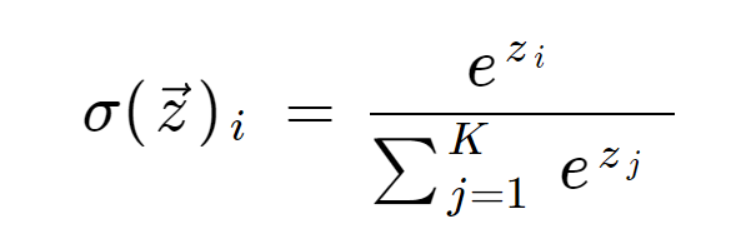

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 tf_roberta_model (TFRoberta  TFBaseModelOutputWithPoo  134998272
 Model)                      lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             200, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                             

## 3. Cấu hình siêu tham số

Xác định lịch learning rate và trọng số weight decay với optimizer là Adam sử dụng thư viện TensorFlow Addons. Biên dịch mô hình với các siêu tham số tùy chỉnh như sau:

In [28]:
step = tf.Variable(0, trainable=False)
schedule = tf.optimizers.schedules.PiecewiseConstantDecay(
    [10000, 15000], [1e-3, 1e-4, 1e-5])

lr = 1e-2 * schedule(step)
wd = lambda: 1e-5 * schedule(step)

- `step = tf.Variable(0, trainable=False)`: Tạo ra một biến TensorFlow step với giá trị khởi tạo là 0. Tham số trainable=False chỉ ra rằng biến này không được cập nhật trong quá trình huấn luyện thông qua lan truyền ngược (backpropagation).

- `schedule = tf.optimizers.schedules.PiecewiseConstantDecay([10000, 15000], [1e-3, 1e-4, 1e-5])`: Tạo ra một đối tượng PiecewiseConstantDecay, một loại lịch trình học phổ biến trong TensorFlow. Lịch trình này sẽ giảm tỷ lệ học (learning rate) theo các bước nhảy cố định. Trong trường hợp này, tỷ lệ học sẽ là 1e-3 cho đến bước thứ 10000, sau đó giảm xuống 1e-4 cho đến bước thứ 15000, và cuối cùng giảm xuống 1e-5 cho tất cả các bước sau đó.

- `lr = 1e-2 * schedule(step)`: Tạo ra tỷ lệ học thực tế lr bằng cách nhân tỷ lệ học từ lịch trình với 1e-2. Tỷ lệ học này sẽ được cập nhật sau mỗi bước huấn luyện dựa trên giá trị của step.

- `wd = lambda: 1e-5 * schedule(step)`: Để tính toán trọng số điều chuẩn (weight decay) wd. Trọng số điều chuẩn này cũng sẽ được cập nhật sau mỗi bước huấn luyện dựa trên giá trị của step.

In [29]:
model.compile(
    optimizer=tfa.optimizers.AdamW(weight_decay=wd,
                                   learning_rate=lr),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'])


Hàm mất mát (trong trường hợp này là CategoricalCrossentropy) đo lường sự khác biệt giữa dự đoán của mô hình và giá trị thực tế. Nó không chỉ quan tâm đến việc mô hình có dự đoán đúng lớp hay không, mà còn quan tâm đến mức độ “chắc chắn” của mô hình trong việc dự đoán đó. Ví dụ, nếu mô hình dự đoán một mẫu thuộc về lớp A với xác suất 51% và lớp B với xác suất 49%, mặc dù dự đoán có thể được coi là đúng nếu mẫu thực sự thuộc về lớp A, nhưng vì mô hình không tự tin vào dự đoán của mình, hàm mất mát sẽ cao.

In [30]:
# Train model
history = model.fit(X_train,
                    y_train,
                    epochs = 20,
                    verbose = 1,
                    validation_split = 0.1,
                    batch_size = 128)

Epoch 1/20
68/68 [==============================] - 311s 1s/step - loss: 22.5953 - accuracy: 0.5316 - val_loss: 22.3114 - val_accuracy: 0.5659
Epoch 2/20
68/68 [==============================] - 15s 215ms/step - loss: 21.9455 - accuracy: 0.6354 - val_loss: 21.4980 - val_accuracy: 0.7416
Epoch 3/20
68/68 [==============================] - 14s 213ms/step - loss: 21.2106 - accuracy: 0.7727 - val_loss: 20.8824 - val_accuracy: 0.8013
Epoch 4/20
68/68 [==============================] - 15s 214ms/step - loss: 20.5945 - accuracy: 0.8224 - val_loss: 20.3174 - val_accuracy: 0.8305
Epoch 5/20
68/68 [==============================] - 15s 214ms/step - loss: 20.0438 - accuracy: 0.8529 - val_loss: 19.8072 - val_accuracy: 0.8441
Epoch 6/20
68/68 [==============================] - 15s 215ms/step - loss: 19.5329 - accuracy: 0.8654 - val_loss: 19.3256 - val_accuracy: 0.8410
Epoch 7/20
68/68 [==============================] - 15s 215ms/step - loss: 19.0218 - accuracy: 0.8819 - val_loss: 18.8512 - val_accu

## 4. Đánh giá mô hình

Trực quan lần lượt accuray và loss của mô hình:

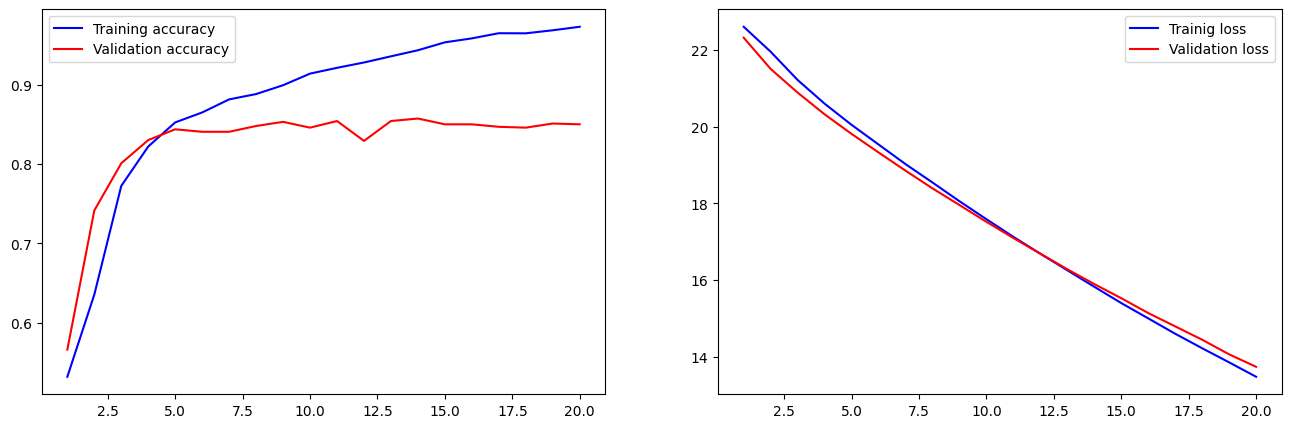

In [31]:
loss = history.history['loss']
acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(16, 5))
# Accuracy
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b', label = 'Trainig loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.legend()

plt.show()

- Như ta thấy, mô hình sau khi huấn luyện qua nhiều epoch đã có thể tối thiểu hóa hàm loss trên cả tập train và test và tăng accuracy trên tập train .
- Ta sẽ chấp nhận mô hình sẽ bị giảm sút accuracy trên tập val để có thể tối ưu hàm loss của mô hình từ đó mô hình có thể khái quát trên dữ liệu khác nhau.



## 5. Kiểm thử trên tập test (chưa được làm giàu)

In [32]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=256)
print("test loss, test acc:", results)

Evaluate on test data
10/10 [==============================] - 11s 586ms/step - loss: 13.7604 - accuracy: 0.8503
test loss, test acc: [13.760354995727539, 0.8502718806266785]


Accucary cuối cùng đạt được xấp xỉ 0.94. Chứng tỏ mô hình đã hoạt
động tốt trên tập dữ liệu

## Lưu model

In [33]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

In [34]:
dir_model = '/content/drive/MyDrive/Colab Notebooks/UDDLL/Model/Tiki_full'
# Lưu kiến trúc của mô hình dưới dạng JSON
model_json = model.to_json()
with open(dir_model+"/model.json", "w") as json_file:
    json_file.write(model_json)

# Lưu trọng số của mô hình
model.save_weights(dir_model+"/model_weights.h5")

## Predict

In [35]:
def to_input(X_pred):
  MAX_LEN = 200
  inputs_pred = [tokenizer(item,
                      max_length = MAX_LEN,
                      padding = 'max_length',
                      truncation = True,
                      return_tensors = 'np')['input_ids'].reshape(MAX_LEN)
            for _, item in X_pred.items()]

  X_pred = np.asarray(inputs_pred)
  return X_pred

In [37]:
def pred_to_lableText(predictions, encoder):
  labels = np.argmax(predictions, axis=-1)
  labels_text = encoder.inverse_transform(labels)
  return labels_text


In [41]:
def predict_csv(df):

  X_pred = df.sentence.copy()
  X_pred = to_input(X_pred)

  with strategy.scope():
    predictions = model.predict(X_pred)

  label_text = pred_to_lableText(predictions, endcoder)

  # Tạo một bản sao của df
  df_new = df.copy()

  # Thêm cột label_text vào df_new
  df_new['pred_label'] = label_text

  return df_new

In [39]:
df_dir = '/content/drive/MyDrive/Colab Notebooks/UDDLL/Data/Youtube Crawl'
df = pd.read_csv(df_dir + '/YoutubeComments(Processed).csv')

df.rename(columns={'content': 'sentence'}, inplace=True)
df.head()

,ID,author,published_at,updated_at,like_count,sentence
0,ahRxhAzyMWI,Tuân tv vlog,2023-11-17T12:31:32Z,2023-11-17T12:31:32Z,0,ai còn xem xin 1 like
1,ahRxhAzyMWI,PHÚ QUÝ THỊNH VƯỢNG,2023-11-17T02:58:56Z,2023-11-17T02:58:56Z,0,Cảm_ơn đời mỗi sớm mai_thức dậy ta có thêm ngà...
2,ahRxhAzyMWI,Kiên Lê,2023-11-16T13:07:02Z,2023-11-16T13:07:02Z,0,Năm nay các nghệ_sĩ đã tập kịch_bản mới chưa nhỉ
3,ahRxhAzyMWI,V Quýt,2023-11-16T04:16:53Z,2023-11-16T04:16:53Z,0,Xem táo như thấy Tết
4,ahRxhAzyMWI,Rain Lee,2023-11-15T14:46:18Z,2023-11-15T14:46:18Z,0,Ông nào sub đấy


In [43]:
X_pred = df.sentence.copy()
X_pred = to_input(X_pred)

In [44]:
with strategy.scope():
  predictions = model.predict(X_pred)

24626/24626 [==============================] - 643s 26ms/step


In [45]:
label_text = pred_to_lableText(predictions, encoder)

# Tạo một bản sao của df
df_new = df.copy()

# Thêm cột label_text vào df_new
df_new['pred_label'] = label_text

In [48]:
pred_df = df_new

pred_df

,ID,author,published_at,updated_at,like_count,sentence,pred_label
0,ahRxhAzyMWI,Tuân tv vlog,2023-11-17T12:31:32Z,2023-11-17T12:31:32Z,0,ai còn xem xin 1 like,positive
1,ahRxhAzyMWI,PHÚ QUÝ THỊNH VƯỢNG,2023-11-17T02:58:56Z,2023-11-17T02:58:56Z,0,Cảm_ơn đời mỗi sớm mai_thức dậy ta có thêm ngà...,positive
2,ahRxhAzyMWI,Kiên Lê,2023-11-16T13:07:02Z,2023-11-16T13:07:02Z,0,Năm nay các nghệ_sĩ đã tập kịch_bản mới chưa nhỉ,neutral
3,ahRxhAzyMWI,V Quýt,2023-11-16T04:16:53Z,2023-11-16T04:16:53Z,0,Xem táo như thấy Tết,neutral
4,ahRxhAzyMWI,Rain Lee,2023-11-15T14:46:18Z,2023-11-15T14:46:18Z,0,Ông nào sub đấy,neutral
...,...,...,...,...,...,...,...
788016,cqWLyDTrAeM,Thi Binh,2019-04-07T08:42:22Z,2019-04-07T08:42:22Z,0,Xem đầu_tiên nhé,neutral
788017,cqWLyDTrAeM,Vi Nguyễn Ngọc Đoan,2019-04-07T08:42:19Z,2019-04-07T08:42:19Z,0,Coi đầu không nhỉ,neutral
788018,cqWLyDTrAeM,anh nguyen,2019-04-07T08:42:17Z,2019-04-07T08:42:17Z,6,trấn thành đỉnh thiêthj,positive
788019,cqWLyDTrAeM,Nhung Mao DH 15G,2019-04-07T08:42:13Z,2019-04-07T08:42:13Z,0,Ahihi,positive


In [47]:
pred_df.to_csv(df_dir+'/Youtube_crawl_pred.csv')

# test load

In [ ]:
# from transformers import TFRobertaModel
# from tensorflow.keras.models import model_from_json


# # Mở tệp JSON và đọc kiến trúc
# with open(dir_model+'/model.json', 'r') as json_file:
#     model_json = json_file.read()

# # Tải mô hình từ JSON
# model = model_from_json(model_json, custom_objects={'TFRobertaModel': TFRobertaModel})

# # Tải trọng số vào mô hình
# model.load_weights(dir_model+"/model_weights.h5")


In [ ]:
# model.compile(
#     optimizer=tfa.optimizers.AdamW(weight_decay=wd,
#                                    learning_rate=lr),
#     loss=tf.keras.losses.CategoricalCrossentropy(),
#     metrics=['accuracy'])


In [ ]:
# # Evaluate the model on the test data using `evaluate`
# print("Evaluate on test data")

# results = model.evaluate(X_test, y_test, batch_size=256)
# print("test loss, test acc:", results)